In [5]:
import seaborn as sns

In [7]:
import pandas as pd
from itertools import chain
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [8]:
sns.set_context("paper", font_scale=1)

from matplotlib import rcParams

# Set global font properties to Arial
rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': 'Arial',
    'pdf.fonttype': 42,  # Embed fonts as Type 3 fonts for compatibility
    'ps.fonttype': 42,
    "text.usetex": False,
    'svg.fonttype': 'none',
})

rcParams.update({
    'font.size': 24,  # Set a default font size
    'legend.fontsize': 16,
    'legend.handlelength': 2,
})
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.labelsize'] = 16

# F1C Bar PLot for Chemeric Read compare

In [9]:
type_names = ["Dorado with Trim", "Dorado w/o Trim", "DC"]

data = {
    type_names[0]: [107266, 6228],
    type_names[1]: [107304, 6228],
    type_names[2]: [9844, 4664],
}

data_with_validated = {
    "value": list(chain.from_iterable([[data[t][0] - data[t][1], data[t][1]] for t in type_names])),
    "data type": list(chain.from_iterable([[i] * 2 for i in type_names])),
    "type": ["Unvalidated", "Validated"] * len(type_names)

}

In [10]:
data_df = pd.DataFrame(
    data_with_validated
)

In [11]:
data_df

,value,data type,type
0,101038,Dorado with Trim,Unvalidated
1,6228,Dorado with Trim,Validated
2,101076,Dorado w/o Trim,Unvalidated
3,6228,Dorado w/o Trim,Validated
4,5180,DC,Unvalidated
5,4664,DC,Validated


In [12]:
# % colors
# \definecolor{mylightred}{RGB}{255,200,200}
# \definecolor{mylightblue}{RGB}{172,188,63}
# \definecolor{mylightgreen}{RGB}{150,220,150}

c1 = [i / 255 for i in (255, 200, 200)]
c2 = [i / 255 for i in (150, 220, 150)]
c3 = [i / 255 for i in (172, 188, 63)]

In [13]:
data_df.groupby("data type")['value'].sum().reset_index()

,data type,value
0,DC,9844
1,Dorado w/o Trim,107304
2,Dorado with Trim,107266


In [14]:
# https://seaborn.pydata.org/tutorial/axis_grids.html#grid-tutorial

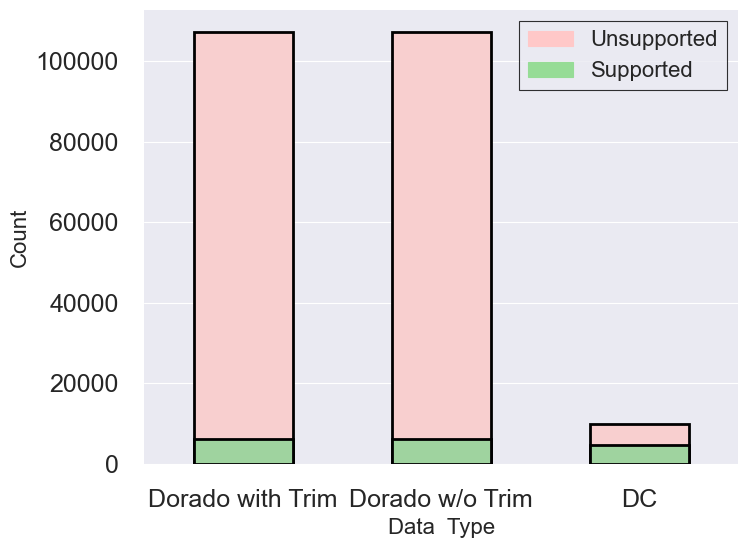

In [15]:
plt.figure(figsize=(8, 6))

bar1 = sns.barplot(data=data_df.groupby("data type")['value'].sum().reset_index(), x="data type", y="value",
                   order=type_names, color=c1, edgecolor="k", linewidth=2, width=0.5)
bar2 = sns.barplot(data=data_df.query("type == 'Validated'"), x="data type", y="value", order=type_names, estimator=sum,
                   color=c2, edgecolor="k", linewidth=2, width=0.5)

# add legend
top_bar = mpatches.Patch(color=c1, label='Unsupported')
bottom_bar = mpatches.Patch(color=c2, label='Supported')
plt.legend(handles=[top_bar, bottom_bar],
           edgecolor='k',
           fancybox=False)
sns.despine(offset=10, trim=True)

plt.ylabel("Count")
plt.xlabel("Data  Type")

plt.tight_layout()
plt.savefig(f'bar_plot_chemeric_read_cmp.pdf',
            dpi=300
            )

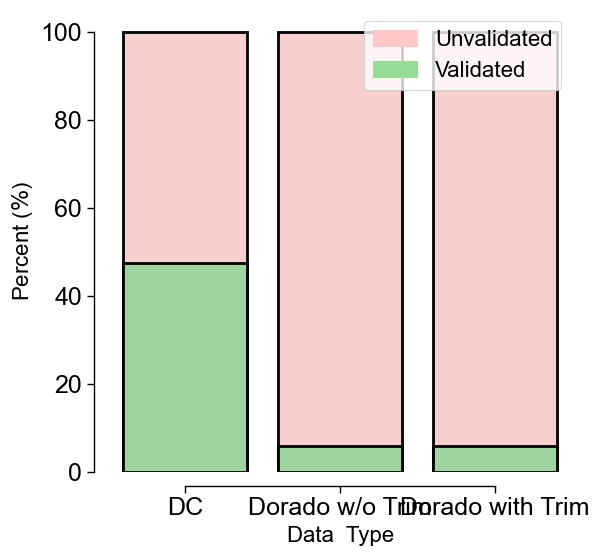

In [11]:
plt.figure(figsize=(6, 6))
total = data_df.groupby("data type")['value'].sum().reset_index()
validated = data_df.query("type == 'Validated'").groupby("data type")['value'].sum().reset_index()
validated['value'] = [i / j * 100 for i, j in zip(validated['value'], total['value'])]
total['value'] = [i / j * 100 for i, j in zip(total['value'], total['value'])]

bar1 = sns.barplot(x="data type", y="value", data=total, color=c1, edgecolor="k", linewidth=2)

# bar chart 2 -> bottom bars (group of 'smoker=Yes')
bar2 = sns.barplot(x="data type", y="value", data=validated, color=c2, edgecolor="k", linewidth=2)

# add legend
top_bar = mpatches.Patch(color=c1, label='Unvalidated')
bottom_bar = mpatches.Patch(color=c2, label='Validated')
plt.legend(handles=[top_bar, bottom_bar])
sns.despine(offset=10, trim=True)

plt.ylabel("Percent ($\%$)")
plt.xlabel("Data  Type")

plt.savefig(f'bar_plot_chemeric_read_cmp_same_height.pdf',
            bbox_inches='tight',
            dpi=300
            )

In [113]:
data_with_validated

{'value': [101038, 6228, 101076, 6228, 5180, 4664],
 'data type': ['Dorado with Trim',
  'Dorado with Trim',
  'Dorado w/o Trim',
  'Dorado w/o Trim',
  'DC',
  'DC'],
 'type': ['Unvalidated',
  'Validated',
  'Unvalidated',
  'Validated',
  'Unvalidated',
  'Validated']}

In [92]:
# Figure 1D, E, F: BLAT, quality and PolyA motif for false positive chimeric artifacts.


# F1D BLAT for internal prediction FP (Dorado chemeric reads - DC chemeric reads)

In [6]:
import json

In [7]:
# load data 
plot_data = json.load(open("data/internal_prediction_seq_blat_top1_indentities.json"))
plot_data_vcap_004 = json.load(open("data/fp_vcap_004_hyena_all_predicts_blat_identities.json"))

In [8]:
len(plot_data)

98807

In [9]:
len(plot_data_vcap_004)

6185

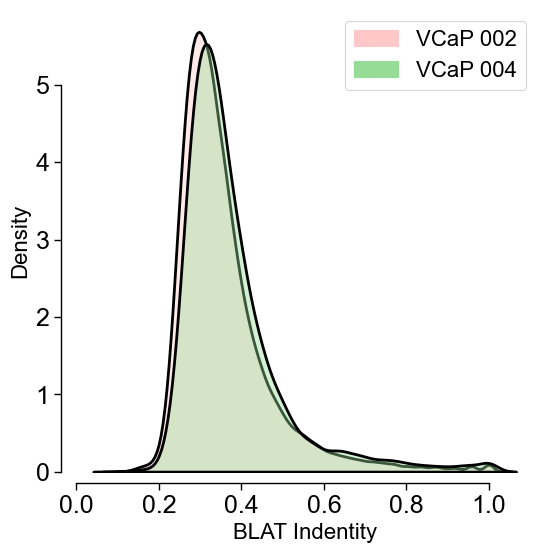

In [19]:
plt.figure(figsize=(6, 6))
sns.kdeplot(data=plot_data, fill=True, color=c1, edgecolor="k", linewidth=2, alpha=.4)
sns.kdeplot(data=plot_data_vcap_004, fill=True, color=c2, edgecolor="k", linewidth=2, alpha=.4)

left_bar = mpatches.Patch(color=c1, label='VCaP 002')
right_bar = mpatches.Patch(color=c2, label='VCaP 004')
plt.legend(handles=[left_bar, right_bar], loc="upper right")

sns.despine(offset=8, trim=True)
plt.xlabel("BLAT Indentity")
# plt.ylabel("Density")
plt.savefig(f'blat_for_fp_internal_prediction_cmp_with_dorado.pdf',
            bbox_inches='tight',
            dpi=300
            )

# F1E Base Quals for internal prediction FP (Dorado chemeric reads - DC chemeric reads)

In [21]:
import json

In [22]:
def plot_qual(file_path):
    from needletail import parse_fastx_file
    quals = []
    for record in parse_fastx_file(file_path):
        current_quals = [ord(i) - 33 for i in list(record.qual)]
        quals.append(sum(current_quals) / len(current_quals))
    return quals

In [23]:
# load data 
plot_data = json.load(open("data/internal_prediction_seq_base_quals.json"))

In [24]:
plot_data = [i - 33 for i in plot_data]

In [25]:
# load data 
plot_qual_left_seq_data = plot_qual("./data/fp_dorado_heyna_vcap002.fq.gz")

In [26]:
len(plot_qual_left_seq_data)

88164

In [27]:
len(plot_data)

146580

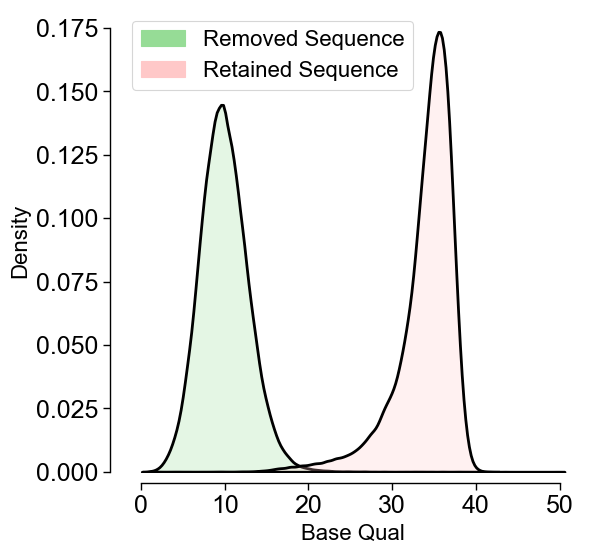

In [31]:
plt.figure(figsize=(6, 6))
sns.kdeplot(data=plot_data, fill=True, color=c2, edgecolor="k", linewidth=2)
sns.kdeplot(data=plot_qual_left_seq_data, fill=True, color=c1, edgecolor="k", linewidth=2)

left_bar = mpatches.Patch(color=c2, label='Removed Sequence')
right_bar = mpatches.Patch(color=c1, label='Retained Sequence')
plt.legend(handles=[left_bar, right_bar], loc="upper left")

sns.despine(offset=8, trim=True)
plt.xlabel("Base Qual")
plt.ylabel("Density")
plt.savefig(f'base_quals_for_fp_internal_prediction_cmp_with_dorado.pdf',
            bbox_inches='tight',
            dpi=300
            )

# Supplemental Figures